In [10]:
import Parity_Data_Generator
import numpy as np
from newESN import ESN
import time

N = 4000   # number of datapoints
n = 3       # n-parity
timescale = 50
rng = np.random.RandomState(42)
slowESN_reservoirSize=300

nParityESN = ESN(inputs=1,
                          neurons=slowESN_reservoirSize,  
                          spectral_radius=1.3, 
                          leak_rate= 0.7,   # adjust leak_rate
                          sparsity=0.95,     # 0.95
                          dt=0.1,
                          noise=0.01,
                          input_scale=5,
                          input_shift=0)
nParityESN_ident_Matrix=np.eye(slowESN_reservoirSize)

In [11]:
def runSomeFastConfigs(spectral_rad, leak_r, d_t, train_parity, test_parity, 
                       train_targets, test_targets,randomstate, num_neurons=50):
    scale = 1/np.std(train_parity)
    shift = -np.mean(train_parity)/np.std(train_parity)
    outputESN = ESN(inputs=slowESN_reservoirSize,
                              neurons=num_neurons,  
                              spectral_radius=spectral_rad,  
                              leak_rate= leak_r,   # adjust leak_rate
                              dt= d_t,
                              sparsity=0.95,
                              noise=0.01,
                              input_scale=scale,
                              input_shift=shift)
    washout=int(len(train_parity)/10)
    outputESN.train(train_parity, train_targets, washout=washout)
    pred_test = outputESN.predict(test_parity)
        
    print("Testing error")
    test_error = np.sqrt(np.mean((pred_test - test_targets) ** 2))
    print(test_error)
    return test_error

def produceFastTrainingData(randomState):
    bits, parity, target = Parity_Data_Generator.generateParityData(N, n, timescale=timescale, 
                                                                    randomstate=randomState)

    # Divide in training and test data
    traintest_cutoff = int(np.ceil(0.7 * len(bits)))
    train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
    train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]
    
    train_predicted_parity = nParityESN.predict(train_bits, nParityESN_ident_Matrix)
    test_predicted_parity = nParityESN.predict(test_bits, nParityESN_ident_Matrix)
    
    return train_predicted_parity, test_predicted_parity, train_targets, test_targets

In [12]:
new_trials = 10
n_neurons_fast = 50
# num_neurons_fast = [100]
delta_t_fast = 0.1
l_rate_fast = np.linspace(0.1, 1, num=10)
sp_rad_fast = np.linspace(0.1, 1, num=10)


run_time = time.time()
iterations, iterationcount = new_trials*len(sp_rad_fast)*len(l_rate_fast), 0


all_errors_fast = [{} for _ in range(new_trials)]
for trial in range(new_trials):
    errors = []
    new_rng = np.random.RandomState(iterationcount)
    new_train_parity, new_test_parity, new_train_targets, new_test_targets = produceFastTrainingData(new_rng)
#     print(new_train_parity.shape)
#     print(new_train_parity)

    for l in l_rate_fast:
        for s in sp_rad_fast:
            print("Neurons:", n_neurons_fast, "Leak-rate:", l, "Spectral-radius:", s,"Delta_t:",delta_t_fast)
            errors.append(runSomeFastConfigs(s,l,delta_t_fast,new_train_parity, new_test_parity, new_train_targets, new_test_targets,new_rng,num_neurons=n_neurons_fast))
            iterationcount = iterationcount + 1
            print("--- Progress: {:.2f}% --- {:.2f} minutes ---".format(iterationcount/iterations*100, ((time.time() - run_time)/60) ))
    ## Save leak-rate,spectral-radius and error in dictionary
    all_errors_fast[trial] = errors

### Average errors
fast_errors_averaged_over_trials = np.zeros(100)
for i in range(len(all_errors_fast)):
    e = all_errors_fast[i]
    fast_errors_averaged_over_trials = np.add(fast_errors_averaged_over_trials, np.array(e))

fast_errors_averaged_over_trials = np.divide(fast_errors_averaged_over_trials, new_trials)
    

            
print("Total time for Testbench:")
print("--- {:.2f} seconds ---".format(time.time() - run_time))
print("--- {:.2f} minutes ---".format(((time.time() - run_time)/60)))

C:\Users\Kevin\Documents\Python-projects\BA-ESN\newESN.py:54: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if readout_weights == None:


Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.1 Delta_t: 0.1


C:\Users\Kevin\Documents\Python-projects\BA-ESN\BlockedLeastSquares.py:101: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._LHS == None:


Testing error
0.363755567149
--- Progress: 0.10% --- 0.33 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.2 Delta_t: 0.1
Testing error
0.385802429353
--- Progress: 0.20% --- 0.44 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.3 Delta_t: 0.1
Testing error
0.376551492248
--- Progress: 0.30% --- 0.54 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.4 Delta_t: 0.1
Testing error
0.379637830808
--- Progress: 0.40% --- 0.66 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.5 Delta_t: 0.1
Testing error
0.459374436367
--- Progress: 0.50% --- 0.77 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.6 Delta_t: 0.1
Testing error
0.470653484903
--- Progress: 0.60% --- 0.89 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.7 Delta_t: 0.1
Testing error
0.430023224095
--- Progress: 0.70% --- 1.00 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.8 Delta_t: 0.1
Testing error
0.447325577825
--- Progress: 0.80% --- 1.11 minutes ---
Neurons: 50 L

In [13]:
import pickle
#### Save Data
with open('dataNewClassRandomProjectionAverage10withScale5Shift.p', 'wb') as outputFile:
    pickle.dump(fast_errors_averaged_over_trials, outputFile)
    pickle.dump(new_trials, outputFile)
    pickle.dump(l_rate_fast, outputFile)
    pickle.dump(sp_rad_fast, outputFile)
#### Load Data
# with open('dataNewClassRandomProjectionAverage10.p', 'rb') as inputFile:
#     fast_errors_averaged_over_trials = pickle.load(inputFile)
#     new_trials = pickle.load(inputFile)
#     l_rate_fast = pickle.load(inputFile)
#     sp_rad_fast = pickle.load(inputFile)

Best Error: 0.343532130094
with leak-rate 0.3
with sp_rad 0.5


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


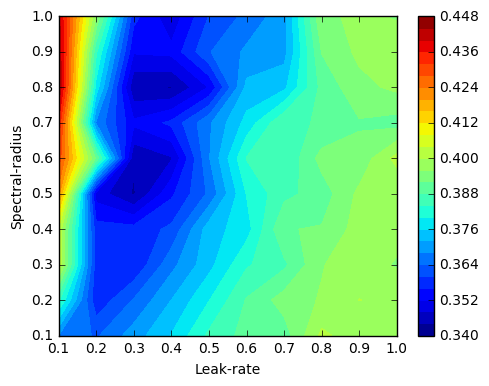

In [14]:
from matplotlib import pyplot
import numpy as np
%matplotlib inline
xx, yy = np.meshgrid(l_rate_fast, sp_rad_fast)
pyplot.figure(figsize=(12,14))
pyplot.subplot(3,2,1)
pyplot.contourf(xx,
                yy,fast_errors_averaged_over_trials.reshape(10,10).T, 30)
# pyplot.title("Randomprojectionmatrix as input to fastESN")
pyplot.xlabel("Leak-rate")
pyplot.ylabel("Spectral-radius")
pyplot.colorbar()
print("Best Error:", np.min(fast_errors_averaged_over_trials))
print("with leak-rate",l_rate_fast[np.argmin(fast_errors_averaged_over_trials.reshape(10,10).T)%10])
print("with sp_rad",sp_rad_fast[np.argmin(fast_errors_averaged_over_trials.reshape(10,10).T)/10])